In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Veri setini yükleme
df = pd.read_csv("traffic.csv")

In [10]:
df

,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4
...,...,...,...,...,...
3035515,17856,165,74.0,0.0233,68.9
3035516,17856,166,11.0,0.0082,64.0
3035517,17856,167,83.0,0.0273,59.1
3035518,17856,168,70.0,0.0188,66.6


In [11]:
# Parametreler
tp = 12  # Tahmin penceresi (1 saat = 12 timestep)
th = 24  # Yakın geçmiş (son 2 saat = 24 timestep)
td = 12  # Günlük periyot (1 gün önce aynı saat dilimi = 12 timestep)
tw = 24  # Haftalık periyot (1 hafta önce aynı saat dilimi = 24 timestep)

In [12]:
timesteps_per_day = 288  # Her lokasyon için günlük 288 gözlem
train_days = 50
test_days = 12
train_size = train_days * timesteps_per_day
test_size = test_days * timesteps_per_day

total_days = df["timestep"].nunique() // timesteps_per_day  # Kaç farklı gün olduğunu hesapla
print(f"Veri setinde toplam {total_days} gün var.")

Veri setinde toplam 62 gün var.


In [13]:
# Veri Setini Sıralama
df = df.sort_values(by=["location", "timestep"]).reset_index(drop=True)

# Train ve Test Setlerini Ayırma
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:train_size + test_size]

# Train ve Test Boyutlarını Kontrol Et
print(f"Train veri boyutu: {len(train_data)} zaman adımı")
print(f"Test veri boyutu: {len(test_data)} zaman adımı")

Train veri boyutu: 14400 zaman adımı
Test veri boyutu: 3456 zaman adımı


In [14]:
# Her lokasyon için girişleri oluşturma
locations = df["location"].unique()
X_recent, X_daily, X_weekly, Y = [], [], [], []

for loc in locations:
    df_loc = df[df["location"] == loc].reset_index(drop=True)
    for i in range(train_size, len(df_loc) - tp):
        recent = df_loc["flow"].iloc[i - th:i].values
        daily = df_loc["flow"].iloc[i - td - timesteps_per_day:i - timesteps_per_day].values
        weekly = df_loc["flow"].iloc[i - tw - 7 * timesteps_per_day:i - 7 * timesteps_per_day].values
        target = df_loc["flow"].iloc[i:i + tp].values
        if len(recent) == th and len(daily) == td and len(weekly) == tw and len(target) == tp:
            X_recent.append(recent)
            X_daily.append(daily)
            X_weekly.append(weekly)
            Y.append(target)

In [15]:
# Numpy dizilerine dönüştürme
X_recent = np.array(X_recent).reshape(-1, th, 1)
X_daily = np.array(X_daily).reshape(-1, td, 1)
X_weekly = np.array(X_weekly).reshape(-1, tw, 1)
Y = np.array(Y).reshape(-1, tp)

In [16]:
num_total = len(Y)
num_train = int(num_total * 0.8)   # %80 train
num_val = num_total - num_train    # %20 val

In [17]:
X_recent_train = X_recent[:num_train]
X_daily_train  = X_daily[:num_train]
X_weekly_train = X_weekly[:num_train]
Y_train        = Y[:num_train]

In [18]:
X_recent_val = X_recent[num_train:]
X_daily_val  = X_daily[num_train:]
X_weekly_val = X_weekly[num_train:]
Y_val        = Y[num_train:]


In [19]:
scaler_y = MinMaxScaler()
scaler_y.fit(Y_train)  # *** SADECE TRAIN ***

MinMaxScaler()

In [20]:
Y_train_scaled = scaler_y.transform(Y_train)
Y_val_scaled = scaler_y.transform(Y_val)

In [21]:
# --- 6. Test setini üret --- #
X_test_recent, X_test_daily, X_test_weekly, Y_test = [], [], [], []
for loc in locations:
    df_loc = test_data[test_data["location"] == loc].reset_index(drop=True)
    for i in range(max(th, td, tw), len(df_loc) - tp):
        recent = df_loc["flow"].iloc[i - th:i].values
        daily = df_loc["flow"].iloc[i - td - timesteps_per_day:i - timesteps_per_day].values
        weekly = df_loc["flow"].iloc[i - tw - 7 * timesteps_per_day:i - 7 * timesteps_per_day].values
        target = df_loc["flow"].iloc[i:i + tp].values
        if len(recent) == th and len(daily) == td and len(weekly) == tw and len(target) == tp:
            X_test_recent.append(recent)
            X_test_daily.append(daily)
            X_test_weekly.append(weekly)
            Y_test.append(target)
X_test_recent = np.array(X_test_recent).reshape(-1, th, 1)
X_test_daily = np.array(X_test_daily).reshape(-1, td, 1)
X_test_weekly = np.array(X_test_weekly).reshape(-1, tw, 1)
Y_test = np.array(Y_test).reshape(-1, tp)

In [22]:
# --- 7. TEST DÖNÜŞÜMÜ (ASLA FIT ETME!) --- #
Y_test_scaled = scaler_y.transform(Y_test)

In [23]:
print("--- Kontrol Özeti ---")
print(f"Orijinal veri uzunluğu: {len(df)}")
print(f"Train veri boyutu: {len(train_data)}")
print(f"Test veri boyutu: {len(test_data)}")
print(f"Model giriş örneği (train+val): {X_recent.shape[0]}")
print(f"Train örnek: {num_train}, Val örnek: {num_val}, Toplam: {num_train + num_val}")
print(f"Test zaman adımı: {test_size}")
print(f"Test (pencere) örnek sayısı: {X_test_recent.shape[0]}")
print("--- ---")

--- Kontrol Özeti ---
Orijinal veri uzunluğu: 3035520
Train veri boyutu: 14400
Test veri boyutu: 3456
Model giriş örneği (train+val): 585480
Train örnek: 468384, Val örnek: 117096, Toplam: 585480
Test zaman adımı: 3456
Test (pencere) örnek sayısı: 3384
--- ---


In [24]:
def build_multi_lstm_model():
    input_recent = Input(shape=(th, 1), name="recent_input")
    input_daily = Input(shape=(td, 1), name="daily_input")
    input_weekly = Input(shape=(tw, 1), name="weekly_input")
    
    lstm_recent = LSTM(64, return_sequences=False, name="lstm_recent")(input_recent)
    lstm_daily = LSTM(32, return_sequences=False, name="lstm_daily")(input_daily)
    lstm_weekly = LSTM(32, return_sequences=False, name="lstm_weekly")(input_weekly)
    
    output_recent = Dense(tp, activation="linear", name="output_recent")(lstm_recent)
    output_daily = Dense(tp, activation="linear", name="output_daily")(lstm_daily)
    output_weekly = Dense(tp, activation="linear", name="output_weekly")(lstm_weekly)
    
    merged_output = Concatenate(name="merged_output")([output_recent, output_daily, output_weekly])
    final_output = Dense(tp, activation="linear", name="final_output")(merged_output)
    
    model = Model(
        inputs=[input_recent, input_daily, input_weekly],
        outputs=[output_recent, output_daily, output_weekly, final_output]
    )
    model.compile(
        optimizer="adam",
        loss={
            "output_recent": "mse",
            "output_daily": "mse",
            "output_weekly": "mse",
            "final_output": "mse",
        },
        metrics={
            "output_recent": ["mae"],
            "output_daily": ["mae"],
            "output_weekly": ["mae"],
            "final_output": ["mae"],
        },
        loss_weights={
            "output_recent": 0.1,
            "output_daily": 0.1,
            "output_weekly": 0.1,
            "final_output": 0.7,
        }
    )

    return model

In [25]:
model = build_multi_lstm_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 recent_input (InputLayer)      [(None, 24, 1)]      0           []                               
                                                                                                  
 daily_input (InputLayer)       [(None, 12, 1)]      0           []                               
                                                                                                  
 weekly_input (InputLayer)      [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_recent (LSTM)             (None, 64)           16896       ['recent_input[0][0]']           
                                                                                              

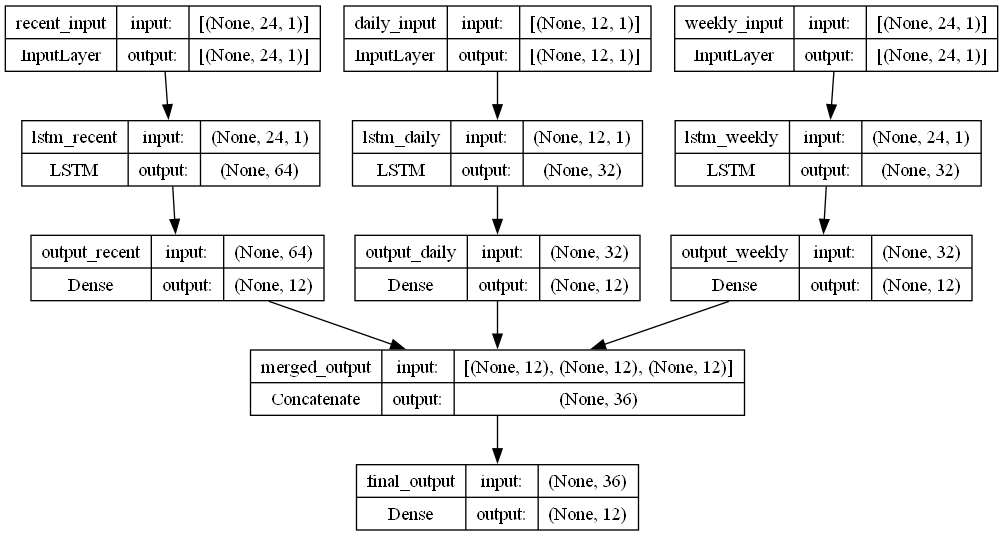

In [26]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_structure_predicted.png")

In [27]:
# Modeli eğitirken:
history = model.fit(
    [X_recent_train, X_daily_train, X_weekly_train],
    {
        "output_recent": Y_train_scaled,
        "output_daily": Y_train_scaled,
        "output_weekly": Y_train_scaled,
        "final_output": Y_train_scaled
    },
    epochs=5,
    batch_size=32,
    validation_data=(
        [X_recent_val, X_daily_val, X_weekly_val],
        {
            "output_recent": Y_val_scaled,
            "output_daily": Y_val_scaled,
            "output_weekly": Y_val_scaled,
            "final_output": Y_val_scaled
        }
    ),
    verbose=1
)


Epoch 1/5
14637/14637 [==============================] - 340s 23ms/step - loss: 0.0031 - output_recent_loss: 0.0035 - output_daily_loss: 0.0076 - output_weekly_loss: 0.0052 - final_output_loss: 0.0021 - output_recent_mae: 0.0333 - output_daily_mae: 0.0542 - output_weekly_mae: 0.0432 - final_output_mae: 0.0303 - val_loss: 0.0023 - val_output_recent_loss: 0.0018 - val_output_daily_loss: 0.0058 - val_output_weekly_loss: 0.0039 - val_final_output_loss: 0.0017 - val_output_recent_mae: 0.0278 - val_output_daily_mae: 0.0505 - val_output_weekly_mae: 0.0412 - val_final_output_mae: 0.0265
Epoch 2/5
14637/14637 [==============================] - 327s 22ms/step - loss: 0.0023 - output_recent_loss: 0.0018 - output_daily_loss: 0.0056 - output_weekly_loss: 0.0037 - final_output_loss: 0.0016 - output_recent_mae: 0.0284 - output_daily_mae: 0.0494 - output_weekly_mae: 0.0393 - final_output_mae: 0.0276 - val_loss: 0.0023 - val_output_recent_loss: 0.0018 - val_output_daily_loss: 0.0058 - val_output_weekly

In [28]:
# Tahminler
Yh_pred, Yd_pred, Yw_pred, Y_pred = model.predict([X_test_recent, X_test_daily, X_test_weekly])

# Sonuçları orijinal ölçeğe döndür
Yh_pred_inv = scaler_y.inverse_transform(Yh_pred)
Yd_pred_inv = scaler_y.inverse_transform(Yd_pred)
Yw_pred_inv = scaler_y.inverse_transform(Yw_pred)
Y_pred_inv  = scaler_y.inverse_transform(Y_pred)


106/106 [==============================] - 1s 5ms/step


In [29]:
print(f"Y_test min/max: {np.min(Y_test):.2f} / {np.max(Y_test):.2f}")
print(f"Y_pred (normalize) min/max: {np.min(Y_pred):.2f} / {np.max(Y_pred):.2f}")
print(f"Y_pred_inv (inverse) min/max: {np.min(Y_pred_inv):.2f} / {np.max(Y_pred_inv):.2f}")

Y_test min/max: 47.00 / 558.00
Y_pred (normalize) min/max: 0.05 / 0.66
Y_pred_inv (inverse) min/max: 45.93 / 560.34


In [30]:
mse_h = mean_squared_error(Y_test, Yh_pred_inv)
mse_d = mean_squared_error(Y_test, Yd_pred_inv)
mse_w = mean_squared_error(Y_test, Yw_pred_inv)
mse_final = mean_squared_error(Y_test, Y_pred_inv)

rmse_h = np.sqrt(mse_h)
rmse_d = np.sqrt(mse_d)
rmse_w = np.sqrt(mse_w)
rmse_final = np.sqrt(mse_final)

r2_h = r2_score(Y_test, Yh_pred_inv)
r2_d = r2_score(Y_test, Yd_pred_inv)
r2_w = r2_score(Y_test, Yw_pred_inv)
r2_final = r2_score(Y_test, Y_pred_inv)

In [31]:
print(f"Test MSE (Recent): {mse_h:.4f}")
print(f"Test MSE (Daily): {mse_d:.4f}")
print(f"Test MSE (Weekly): {mse_w:.4f}")
print(f"Test MSE (Final): {mse_final:.4f}")

Test MSE (Recent): 1982.5830
Test MSE (Daily): 6965.1920
Test MSE (Weekly): 7135.5249
Test MSE (Final): 1893.7849


In [32]:
print(f"Test RMSE (Recent): {rmse_h:.4f}")
print(f"Test RMSE (Daily): {rmse_d:.4f}")
print(f"Test RMSE (Weekly): {rmse_w:.4f}")
print(f"Test RMSE (Final): {rmse_final:.4f}")

Test RMSE (Recent): 44.5262
Test RMSE (Daily): 83.4577
Test RMSE (Weekly): 84.4720
Test RMSE (Final): 43.5176


In [33]:
print(f"Test R² (Recent): {r2_h:.4f}")
print(f"Test R² (Daily): {r2_d:.4f}")
print(f"Test R² (Weekly): {r2_w:.4f}")
print(f"Test R² (Final): {r2_final:.4f}")


Test R² (Recent): 0.8960
Test R² (Daily): 0.6351
Test R² (Weekly): 0.6261
Test R² (Final): 0.9007


In [34]:
def plot_prediction(actual, prediction, moving_average, location):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Gerçek Değer", color="blue")
    plt.plot(prediction, label="Model Tahmini", color="orange")
    plt.plot(moving_average, label="Hareketli Ortalama", color="green", linestyle="dashed")
    plt.xlabel("Zaman Adımları")
    plt.ylabel("Trafik Akışı")
    plt.title(f"Lokasyon: {location} için Trafik Akışı Tahmini")
    plt.legend()
    plt.show()

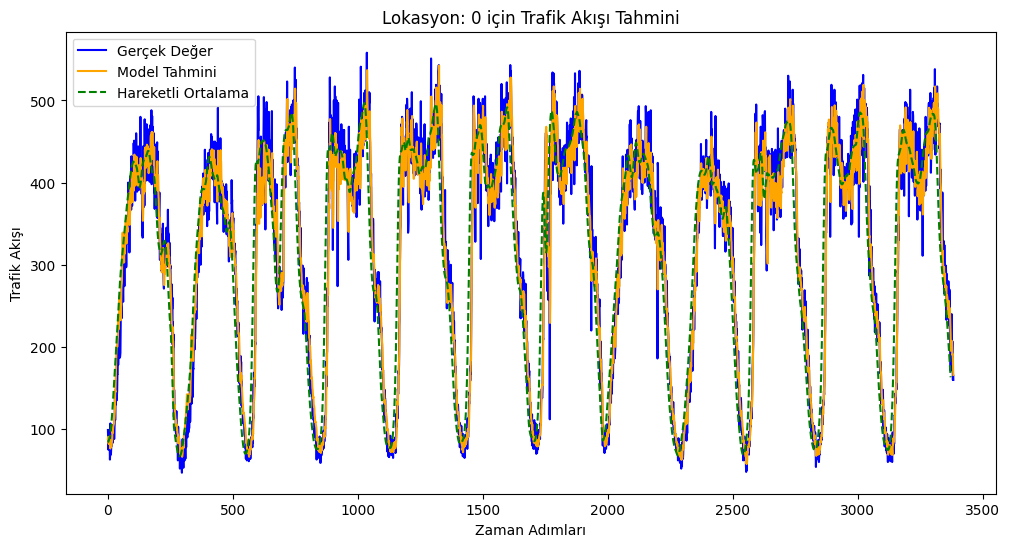

In [35]:
window_size = 12
test_moving_average = np.convolve(Y_test.mean(axis=1), np.ones(window_size)/window_size, mode="valid")
plot_prediction(Y_test[:, 0], Y_pred_inv[:, 0], test_moving_average, location=locations[0])

In [36]:
print("Gerçek değerler (ilk 10):", np.round(Y_test[:10, 0], 3))
print("Tahmin edilen değerler (ilk 10):", np.round(Y_pred_inv[:10, 0], 3))

Gerçek değerler (ilk 10): [99. 87. 75. 88. 82. 99. 76. 82. 63. 69.]
Tahmin edilen değerler (ilk 10): [87.933 90.622 86.557 82.329 85.7   82.465 87.893 82.663 82.924 77.06 ]
